# Lesson 22: Unsupervised learning demonstration

This notebook demonstrates key concepts and tools for training unsupervised models.

1. Clustering
    - Kmeans
    - Hierarchical
    - DBSCAN
    - Clustering evaluation
    - Determining cluster number

2. Dimensionality reduction
    - PCA
    - Gaussian Random Projection
    - Feature Agglomeration
    - t-SNE

3. Association rule learning
4. Anomaly detection


## Notebook set up

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

### Dataset

In [2]:
# Generate synthetic dataset
data = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=3,
    # center_box=(-1.0, 1.0),
    cluster_std=0.6,
    random_state=0
)

# Create dataframe with feature columns
df = pd.DataFrame(data[0], columns=[f'feature_{i}' for i in range(data[0].shape[1])])

# Standard scale the features
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()

,feature_0,feature_1
0,-0.972185,0.046031
1,0.652719,0.999023
2,-1.227944,0.217025
3,-1.083584,0.128545
4,-1.608505,-0.250835


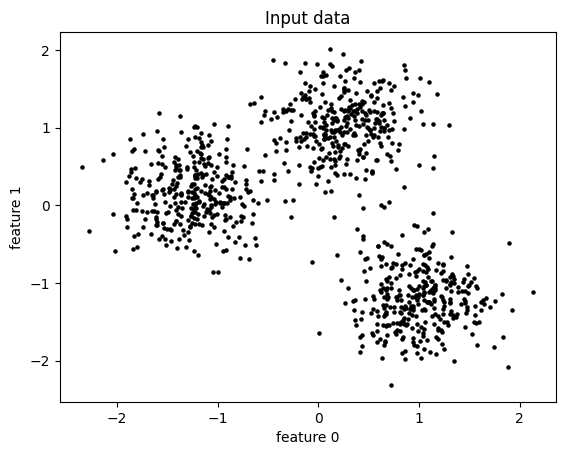

In [3]:
plt.title('Input data')
plt.scatter(df['feature_0'], df['feature_1'], s=5, c='black')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

## 1. Clustering

### 1.1. KMeans

KMeans partitions data into k clusters by minimizing within-cluster variance. Each cluster is represented by its centroid.

Scikit-learn [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation

In [4]:
# Fit KMeans clustering
kmeans = KMeans(n_clusters=7, max_iter=10000, random_state=315)
kmeans_labels = kmeans.fit_predict(df)

# Calculate metrics
kmeans_silhouette = silhouette_score(df, kmeans_labels)

print(f'KMeans - Silhouette: {kmeans_silhouette:.3f}')

KMeans - Silhouette: 0.400


### 1.2. Hierarchical clustering

Hierarchical clustering builds a tree of clusters by either merging clusters based on distance metrics.

Scikit-learn [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) implementation

In [5]:
# Fit hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(df)

# Calculate metrics
hierarchical_silhouette = silhouette_score(df, hierarchical_labels)

print(f'Hierarchical - Silhouette: {hierarchical_silhouette:.3f}')

Hierarchical - Silhouette: 0.514


### 1.3. DBSCAN

DBSCAN groups points that are closely packed together, marking points in low-density regions as outliers. It does not require specifying the number of clusters.

Scikit-learn [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) implementation

In [6]:
# Fit DBSCAN clustering
dbscan = DBSCAN(eps=0.16)
dbscan_labels = dbscan.fit_predict(df)

# Count clusters (excluding noise points labeled as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'DBSCAN found {n_clusters} clusters and {n_noise} noise points')

# Calculate metrics (excluding noise points)
mask = dbscan_labels != -1
dbscan_silhouette = silhouette_score(df[mask], dbscan_labels[mask])

print(f'DBSCAN - Silhouette: {dbscan_silhouette:.3f}')

DBSCAN found 3 clusters and 72 noise points
DBSCAN - Silhouette: 0.683


### 1.4. Clustering evaluation

#### 1.4.1. Silhouette score

The silhouette score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the point is well matched to its own cluster and poorly matched to neighboring clusters. A score near 0 indicates overlapping clusters, and negative values suggest the point may be assigned to the wrong cluster.

In [7]:
# Create comparison dataframe
clustering_results = pd.DataFrame({
    'Method': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Silhouette': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette]
})

clustering_results

,Method,Silhouette
0,KMeans,0.400152
1,Hierarchical,0.514280
2,DBSCAN,0.682974


#### 1.4.2. Scatter plots

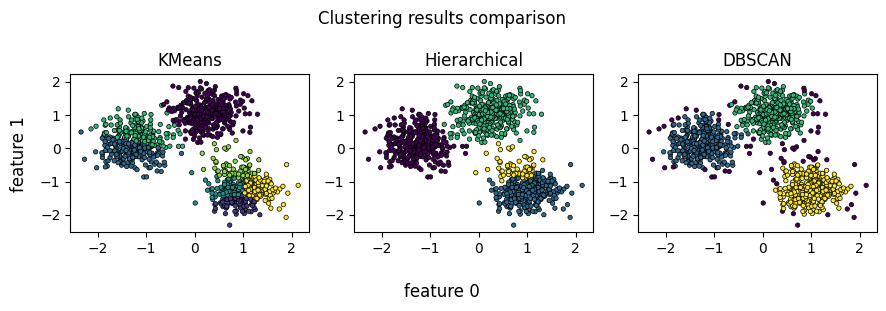

In [8]:
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

fig.suptitle('Clustering results comparison')
fig.supxlabel('feature 0')
fig.supylabel('feature 1')

# KMeans
axes[0].scatter(df['feature_0'], df['feature_1'], c=kmeans_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[0].set_title('KMeans')

# Hierarchical
axes[1].scatter(df['feature_0'], df['feature_1'], c=hierarchical_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[1].set_title('Hierarchical')

# DBSCAN
axes[2].scatter(df['feature_0'], df['feature_1'], c=dbscan_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[2].set_title('DBSCAN')

plt.tight_layout()
plt.show()

#### 1.4.3. Dendrogram (hierarchical clustering only)

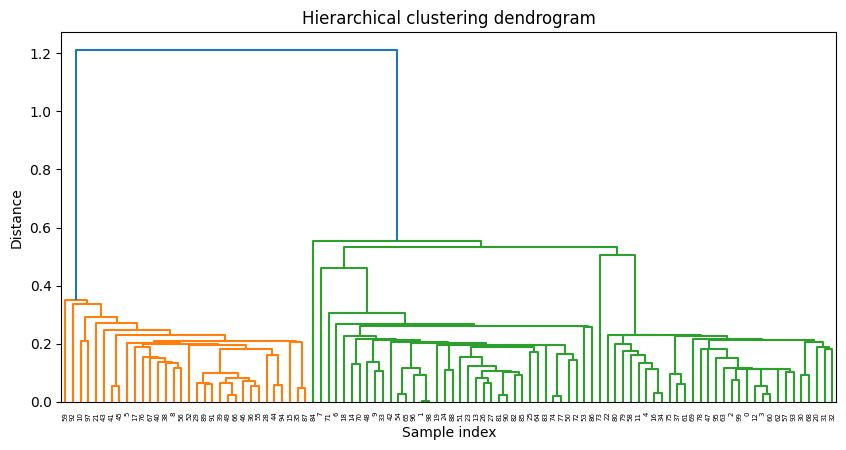

In [9]:
# Create dendrogram
linkage_matrix = linkage(df.iloc[:100])

plt.figure(figsize=(10, 4.8))
dendrogram(linkage_matrix)
plt.title('Hierarchical clustering dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

### 1.5. Determining cluster number: elbow method

The elbow method helps determine the optimal number of clusters by plotting the within-cluster sum of squares (inertia) for different values of k. The optimal k is at the 'elbow' where the rate of decrease sharply changes.

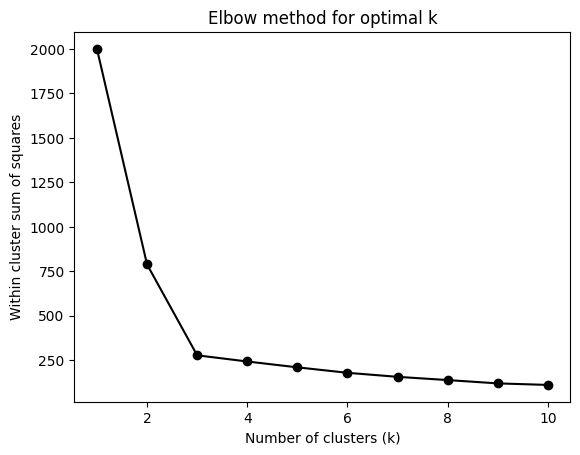

In [10]:
# Calculate inertia for different numbers of clusters
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=315, n_init=10)
    kmeans_temp.fit(df)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
plt.plot(k_range, inertias, marker='o', color='black')
plt.title('Elbow method for optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within cluster sum of squares')
plt.show()

## 2. Dimensionality reduction

### 2.1. High dimensional dataset

In [11]:
# Create high dimensional dataset by multiplying each feature with random noise

noise_features = {}

for feature in df.columns:

    for j in range(5):

        noise = np.random.uniform(low=-1, high=1, size=len(df))
        noise_features[f'{feature}_noise_{j}'] = df[feature] + noise

# Create new dataframe with 10 features
noise_df = pd.DataFrame(noise_features)

print(f'Original dataset shape: {df.shape}')
print(f'High dimensional dataset shape: {noise_df.shape}')
noise_df.head()

Original dataset shape: (1000, 2)
High dimensional dataset shape: (1000, 10)


,feature_0_noise_0,feature_0_noise_1,feature_0_noise_2,feature_0_noise_3,feature_0_noise_4,feature_1_noise_0,feature_1_noise_1,feature_1_noise_2,feature_1_noise_3,feature_1_noise_4
0,-1.800929,-1.249095,-0.059396,-1.905900,-0.548341,-0.484965,0.398172,0.942654,0.796433,0.181442
1,0.892246,-0.140322,0.808942,1.351568,0.604107,1.612694,1.561903,1.096690,1.853366,1.949810
2,-0.976584,-1.639840,-1.461157,-1.458664,-1.290741,-0.239477,0.454584,-0.181955,-0.461425,0.192949
3,-0.546571,-0.577876,-1.851457,-1.164612,-1.081511,0.497147,0.272535,0.588867,0.868013,-0.406110
4,-1.001980,-0.866735,-0.804485,-1.648591,-0.675146,-0.313581,-0.821217,-0.890754,0.495357,-0.811600


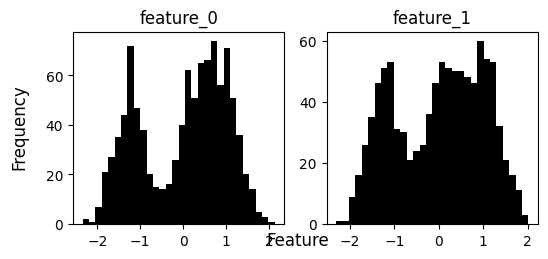

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))

fig.supxlabel('Feature')
fig.supylabel('Frequency')

# Original data
for i, feature in enumerate(df.columns):
    axs[i].set_title(f'{feature}')
    axs[i].hist(df[feature], bins=30, color='black')

plt.show()

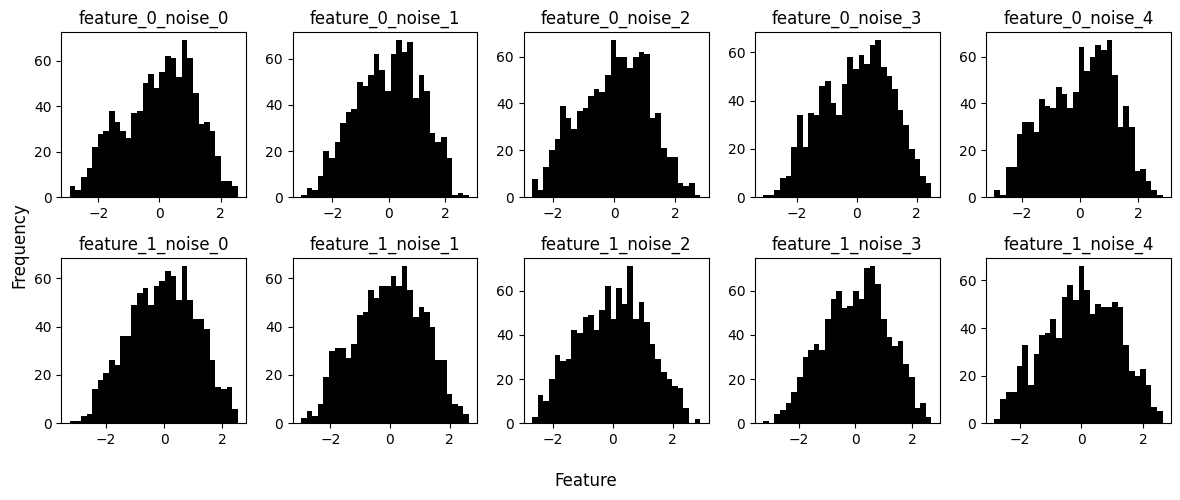

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()

fig.supxlabel('Feature')
fig.supylabel('Frequency')

# Original data
for i, feature in enumerate(noise_df.columns):
    axs[i].set_title(f'{feature}')
    axs[i].hist(noise_df[feature], bins=30, color='black')

plt.tight_layout()
plt.show()

### 2.2. PCA

Principal Component Analysis transforms data to a new coordinate system where the greatest variance lies on the first coordinate (first principal component).

Scikit-learn [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation

In [14]:
# Apply PCA
pca = PCA(n_components=5, random_state=315)
pca_components = pca.fit_transform(noise_df)

X_pca = pd.DataFrame(pca_components, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4
0,-2.377581,-1.145054,-0.179472,1.028979,-0.342474
1,-1.413147,3.714920,-0.630138,-0.106807,0.388280
2,-2.113887,-2.167094,-0.719712,-0.064195,-0.030507
3,-2.241649,-1.032884,0.656905,-0.116289,-0.724304
4,-0.875254,-2.291129,-0.033789,-0.074266,-0.464987


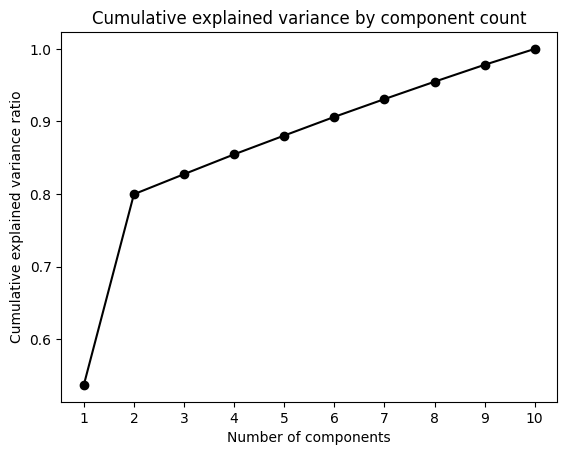

In [15]:
# Evaluate cumulative explained variance across a range of components
comp_range = range(1, 11)
cumulative_variance = []

for n_comp in comp_range:
    pca_temp = PCA(n_components=n_comp, random_state=315)
    pca_temp.fit(noise_df)
    cumulative_variance.append(np.sum(pca_temp.explained_variance_ratio_))

# Plot cumulative explained variance
plt.plot(comp_range, cumulative_variance, marker='o', color='black')
plt.title('Cumulative explained variance by component count')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.xticks(comp_range)
plt.show()

### 2.3. Gaussian Random Projection

Gaussian Random Projection reduces dimensionality by projecting data onto a lower-dimensional space using a random matrix with components drawn from a Gaussian distribution.

Scikit-learn [GaussianRandomProjection](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html) implementation

In [16]:
# Apply Gaussian Random Projection
grp = GaussianRandomProjection(n_components=2, random_state=315)
X_grp = grp.fit_transform(noise_df)

# Create GRP dataframe
grp_df = pd.DataFrame(X_grp, columns=['GRP1', 'GRP2'])
grp_df.head()

,GRP1,GRP2
0,1.826422,0.694155
1,-3.344232,-2.572185
2,0.077651,-0.182426
3,-0.499105,-1.115468
4,1.730110,0.123864


### 2.4. Feature Agglomeration

Feature Agglomeration uses hierarchical clustering to group similar features together, reducing dimensionality while preserving the structure of the data.

Scikit-learn [FeatureAgglomeration](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html) implementation

In [17]:
# Apply Feature Agglomeration
fa = FeatureAgglomeration(n_clusters=2)
X_fa = fa.fit_transform(noise_df)

# Create FA dataframe
fa_df = pd.DataFrame(X_fa, columns=['FA1', 'FA2'])
fa_df.head()

,FA1,FA2
0,-1.112732,0.366747
1,0.703308,1.614892
2,-1.365397,-0.047065
3,-1.044405,0.364090
4,-0.999388,-0.468359


### 2.5. t-SNE

t-Distributed Stochastic Neighbor Embedding is a nonlinear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data.

Scikit-learn [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation

In [18]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=315, perplexity=30)#, n_iter=1000)
X_tsne = tsne.fit_transform(noise_df)

# Create t-SNE dataframe
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df.head()

,TSNE1,TSNE2
0,-22.135517,-4.849995
1,-1.298629,33.706390
2,-19.866566,-14.608229
3,-18.666292,-0.906190
4,-16.114214,-18.192892


### 2.6. Dimensionality reduction comparison

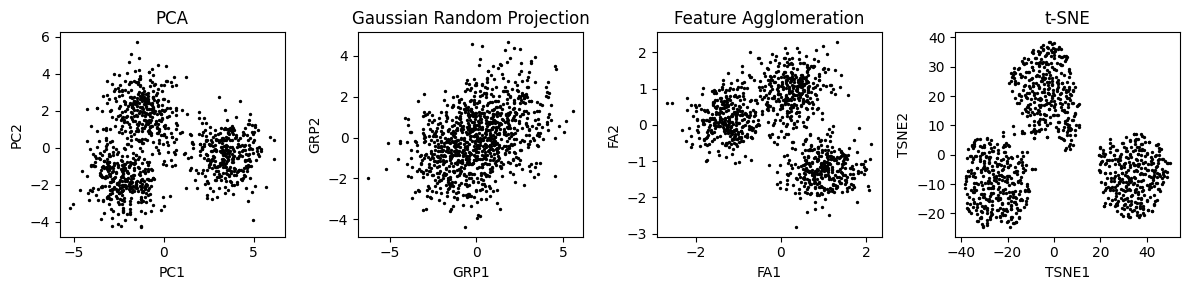

In [19]:
ncols = 4
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

# PCA
axes[0].scatter(X_pca.values[:, 0], X_pca.values[:, 1], c='black', s=2)
axes[0].set_title('PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Gaussian Random Projection
axes[1].scatter(X_grp[:, 0], X_grp[:, 1], c='black', s=2)
axes[1].set_title('Gaussian Random Projection')
axes[1].set_xlabel('GRP1')
axes[1].set_ylabel('GRP2')

# Feature Agglomeration
axes[2].scatter(X_fa[:, 0], X_fa[:, 1], c='black', s=2)
axes[2].set_title('Feature Agglomeration')
axes[2].set_xlabel('FA1')
axes[2].set_ylabel('FA2')

# t-SNE
axes[3].scatter(X_tsne[:, 0], X_tsne[:, 1], c='black', s=2)
axes[3].set_title('t-SNE')
axes[3].set_xlabel('TSNE1')
axes[3].set_ylabel('TSNE2')

plt.tight_layout()
plt.show()